In [1]:
outputs_path = '/media/mesteban/External Toshiba/newpaper/niterations_study'

In [2]:
import re
import os
import pandas as pd
import mmap 
import matplotlib.pyplot as plt
import json
import ast

from datetime import datetime


def collect_results(lipi_output_path):
    results = {}
    format_string = "%Y-%m-%d %H:%M:%S,%f"

    # Find master log file inside log directory
    lipizzaner_output_log_path = lipi_output_path + "/log"
    for filename in os.listdir(lipizzaner_output_log_path):
        if re.match(".*\.log", filename):
            with open(os.path.join(lipizzaner_output_log_path , filename), 'r') as f:
                
                # Parse FID score
                match = re.search('Best result:.* = \((.*), (.*)\)', f.read())
                results["score"] = float(match.group(1)) if (match is not None) else -1

                # Parse first timestamp and execution time
                f.seek(0)
                log_lines = f.readlines()
                
                start_time = re.search('(.*?)\sINFO', log_lines[0])
                end_time = re.search('(.*?)\sINFO', log_lines[len(log_lines)-1])

                results["timestamp"] = datetime.strptime(start_time.group(1), format_string)
                results["time"] = (datetime.strptime(end_time.group(1), format_string) - datetime.strptime(start_time.group(1), format_string)).total_seconds()

                # Parse path
                results["path"] = lipi_output_path
    
    # Find clients logs
    lipizzaner_output_clients_path = lipi_output_path + "/lipizzaner_gan/distributed/covid"
    for current_dir, subdirs, files in os.walk(lipizzaner_output_clients_path):
        
        # Find log file (there should be one for each client in the grid)
        for filename in files:
            if re.match(".*\.log", filename):
                with open(os.path.join(current_dir , filename), 'r') as f:

                    g_loss = []
                    d_loss = []

                    # Parse iterations losses
                    lines = f.readlines()
                    for line in lines:
                        if re.search('Iteration=\d*, f', line):
                            # Find values
                            generator_loss = float(re.search('f\(Generator\(x\)\)=(\d+\..+?),', line).group(1))
                            discriminator_loss = float(re.search('f\(Discriminator\(x\)\)=(\d+\..+?),', line).group(1))

                            # Parser exception
                            if generator_loss is None or discriminator_loss is None:
                                raise Exception("Parser error")

                            g_loss.append(generator_loss)
                            d_loss.append(discriminator_loss)
                        
                        if re.search('Parameters: ({.*})', line):
                            parameters = ast.literal_eval(str(re.search('Parameters: ({.*})', line).group(1)))
                            results["n_iterations"] = parameters["trainer"]['n_iterations']



                    results["generator_loss"] = g_loss
                    results["discriminator_loss"] = d_loss


    return results





# The lipizzaner output dir is where the log dir exists.
regex = re.compile('(.*)/log$')
results_list = []

# Find all subdirs with log folder (assume that every directory with log folder is a lipizzaner output)
# os.walk returns a generator, that creates a tuple of values (current_path, directories in current_path, files in current_path).
for subdir, _, _ in os.walk(outputs_path):
    lipi_output = regex.match(subdir)

    # Collect results for especific execution
    if lipi_output:
        result = collect_results(lipi_output.group(1))     
        results_list.append(result)


# Create dataframe and sort by time
df = pd.DataFrame(results_list)
df.sort_values(['timestamp'], 0, inplace=True)
df.head(20)



,score,timestamp,time,path,n_iterations,generator_loss,discriminator_loss
0,1.401579,2021-03-26 23:30:20.398,277.001,/media/mesteban/External Toshiba/newpaper/nite...,100,"[0.6736683905124664, 0.6736683905124664, 0.673...","[1.3842734277248383, 1.3842734277248383, 1.384..."
2,1.308234,2021-03-26 23:35:59.244,274.073,/media/mesteban/External Toshiba/newpaper/nite...,100,"[0.6763888299465179, 0.6763888299465179, 0.676...","[1.3883309662342072, 1.3883309662342072, 1.388..."
3,1.449147,2021-03-26 23:41:35.011,269.448,/media/mesteban/External Toshiba/newpaper/nite...,100,"[0.7100170850753784, 0.7100170850753784, 0.710...","[1.3852016866207122, 1.3852016866207122, 1.385..."
4,1.281204,2021-03-26 23:47:06.077,270.016,/media/mesteban/External Toshiba/newpaper/nite...,100,"[0.6675161004066468, 0.6675161004066468, 0.667...","[1.3871452689170838, 1.3871452689170838, 1.387..."
5,1.404661,2021-03-26 23:52:37.737,272.905,/media/mesteban/External Toshiba/newpaper/nite...,100,"[0.6668988555669785, 0.6668988555669785, 0.666...","[1.3943519592285156, 1.3943519592285156, 1.394..."
6,1.356059,2021-03-26 23:58:12.305,272.842,/media/mesteban/External Toshiba/newpaper/nite...,100,"[0.6671964883804321, 0.6671964883804321, 0.667...","[1.3901659727096558, 1.3901659727096558, 1.390..."
7,1.416819,2021-03-27 00:03:46.817,272.443,/media/mesteban/External Toshiba/newpaper/nite...,100,"[0.6977215111255646, 0.6977215111255646, 0.697...","[1.363197034597397, 1.363197034597397, 1.36319..."
8,1.414166,2021-03-27 00:09:21.309,274.833,/media/mesteban/External Toshiba/newpaper/nite...,100,"[0.7254003703594207, 0.7254003703594207, 0.725...","[1.3753728985786438, 1.3753728985786438, 1.375..."
9,1.336992,2021-03-27 00:14:57.863,273.427,/media/mesteban/External Toshiba/newpaper/nite...,100,"[0.6953966975212097, 0.6953966975212097, 0.695...","[1.3813389241695404, 1.3813389241695404, 1.381..."
1,1.375389,2021-03-27 00:20:32.915,273.915,/media/mesteban/External Toshiba/newpaper/nite...,100,"[0.6524707823991776, 0.6524707823991776, 0.652...","[1.3943104565143585, 1.3943104565143585, 1.394..."


In [23]:
labels = [100,200,300,400,500,600,700,800,900,1000]

scores_dataframe = pd.DataFrame(columns=["100","200","300","400","500","600","700","800","900","1000"])
scores_dic = {}
for i in labels:
    #scores_dataframe[str(i)] = df.loc[df['n_iterations']==i]['score']
    scores_dic[str(i)] = df.loc[df['n_iterations']==i]['score'].tolist()

scores_dataframe = pd.DataFrame(scores_dic)
scores_dataframe.head()

,100,200,300,400,500,600,700,800,900,1000
0,1.401579,1.579441,1.507401,1.672437,1.742601,1.738473,1.667770,1.618678,1.610972,1.721738
1,1.308234,1.643878,1.536936,1.555689,1.659657,1.633849,1.726496,1.630809,1.553575,1.704718
2,1.449147,1.486233,1.496432,1.612958,1.645127,1.765750,1.675294,1.583953,1.670111,1.652789
3,1.281204,1.516595,1.576285,1.678395,1.579614,1.712646,1.622468,1.632372,1.580894,1.662356
4,1.404661,1.486787,1.541747,1.715361,1.655094,1.696582,1.689367,1.725760,1.721610,1.621054


In [31]:
scores_dataframe.describe().round(decimals=3)

,100,200,300,400,500,600,700,800,900,1000
count,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000
mean,1.382,1.497,1.578,1.615,1.645,1.688,1.653,1.650,1.646,1.687
std,0.056,0.084,0.080,0.069,0.079,0.063,0.065,0.064,0.049,0.056
min,1.281,1.364,1.405,1.497,1.471,1.547,1.537,1.525,1.550,1.588
25%,1.345,1.442,1.521,1.558,1.593,1.644,1.609,1.610,1.618,1.655
50%,1.388,1.484,1.577,1.613,1.650,1.693,1.636,1.634,1.640,1.702
75%,1.413,1.518,1.618,1.667,1.688,1.736,1.689,1.669,1.669,1.722
max,1.527,1.689,1.744,1.761,1.798,1.824,1.792,1.859,1.758,1.822


<AxesSubplot:>

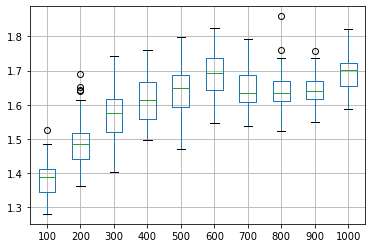

In [26]:
scores_dataframe.boxplot()

In [6]:
from scipy import stats

def normality_test(distribution):
    k2, p = stats.normaltest(distribution)
    alpha = 1e-3
    is_score_normal = True if p < alpha else False # Accept H0 or  Reject H0
    return is_score_normal


In [28]:

score_means = []
score_medians = []
score_maximums = []
time_medians = []
time_means = []
time_maximus = []
labels = [100,200,300,400,500,600,700,800,900,1000]

for i in labels:

    print("--------- {} iterations ----------".format(i))

    df_aux = df[df['n_iterations']==i][['timestamp','score','time']]
    #print(df_aux.to_string(index=False))

    print(round(df_aux['score'].mean(),3))
    print(round(df_aux['score'].std(),3))
    print(round(df_aux['score'].min(),3))
    print(round(df_aux['score'].quantile(.25),3))
    print(round(df_aux['score'].quantile(.50),3))
    print(round(df_aux['score'].quantile(.75),3))
    print(round(df_aux['score'].max(),3))
    print(normality_test(df_aux['score']))
    print("")

    print(round(df_aux['time'].mean(),3))
    print(round(df_aux['time'].std(),3))
    print(round(df_aux['time'].min(),3))
    print(round(df_aux['time'].quantile(.25),3))
    print(round(df_aux['time'].quantile(.50),3))
    print(round(df_aux['time'].quantile(.75),3))
    print(round(df_aux['time'].max(),3))
    print(normality_test(df_aux['time']))

    print("")

    score_means.append(round(df_aux['score'].mean(),3))
    score_medians.append(round(df_aux['score'].median(),3))
    score_maximums.append(round(df_aux['score'].max(),3))

    time_means.append(round(df_aux['time'].mean(),3))
    time_medians.append(round(df_aux['time'].median(),3))
    time_maximus.append(round(df_aux['time'].max(),3))


--------- 100 iterations ----------
1.382
0.056
1.281
1.345
1.388
1.413
1.527
False

283.228
15.147
261.577
272.906
276.527
292.195
329.33
False

--------- 200 iterations ----------
1.497
0.084
1.364
1.442
1.484
1.518
1.689
False

419.976
6.734
409.988
416.47
418.414
420.635
442.881
True

--------- 300 iterations ----------
1.578
0.08
1.405
1.521
1.577
1.618
1.744
False

604.965
10.172
589.101
598.654
602.828
611.409
631.118
False

--------- 400 iterations ----------
1.615
0.069
1.497
1.558
1.613
1.667
1.761
False

785.087
19.938
756.873
764.068
794.943
804.059
805.566
True

--------- 500 iterations ----------
1.645
0.079
1.471
1.593
1.65
1.688
1.798
False

930.484
9.817
916.517
922.88
927.768
939.418
948.608
False

--------- 600 iterations ----------
1.688
0.063
1.547
1.644
1.693
1.736
1.824
False

1227.278
65.779
1140.833
1173.954
1193.662
1298.87
1341.893
True

--------- 700 iterations ----------
1.653
0.065
1.537
1.609
1.636
1.689
1.792
False

1316.712
51.293
1254.276
1265.08
1325.

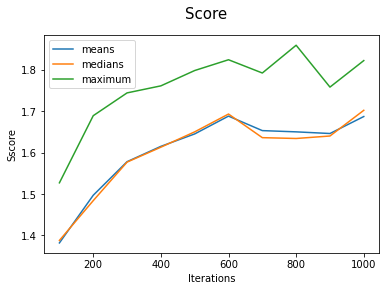

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(labels, score_means, label="means")
plt.plot(labels, score_medians, label="medians")
plt.plot(labels, score_maximums, label="maximum")
fig.suptitle('Score', fontsize=15)
plt.xlabel('Iterations', fontsize=10)
plt.ylabel('Sscore', fontsize=10)
plt.legend()
plt.savefig("score.png",facecolor='w', dpi=300)


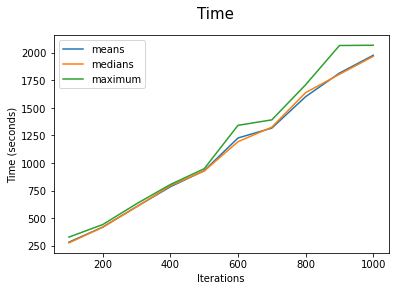

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(labels, time_means, label="means")
plt.plot(labels, time_medians, label="medians")
plt.plot(labels, time_maximus, label="maximum")
fig.suptitle('Time', fontsize=15)
plt.xlabel('Iterations', fontsize=10)
plt.ylabel('Time (seconds)', fontsize=10)
plt.legend()
plt.savefig("time.png",facecolor='w',dpi=300)


In [10]:
from scipy.stats import shapiro, wilcoxon, f_oneway, iqr
import numpy as np
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
# The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. 
# In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.
def nonparametric_pairwise_test(data1, data2, alpha):
    val1, val2 = np.array(data1), np.array(data2)
    if np.median(val1) < np.median(val2):
        aux = data2
        data2 = data1
        data1 = aux
    stat, p = wilcoxon(data1, data2, alternative='greater')
    return stat, p, p<alpha

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
# The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. 
# The test is applied to samples from two or more groups, possibly with differing sizes.
def parametric_pairwise_test(data1, data2, alpha):
    stat, p = f_oneway(data1, data2)
    return stat, p, p<alpha

In [11]:
list(combinations(labels, 2))[0][0]
df[df['score']==100]

NameError: name 'combinations' is not defined

In [ ]:

from itertools import combinations

alpha = 0.01

for pair in list(combinations(labels, 2)):

    d0 = df[df['n_iterations']==pair[0]]['score']
    d1 = df[df['n_iterations']==pair[1]]['score']

    d0_normality = normality_test(d0)
    d1_normality = normality_test(d1)

    # Parametric
    if d0_normality and d1_normality:
        stat, p, reject = parametric_pairwise_test(d0,d1,alpha)
        if reject:
            print("{}:{} - normal distributions - parametric - one-way ANOVA - p:{} - alpha:{} - reject: {} - DIFFERENCE".format(pair[0],pair[1],p, alpha, reject))
        else:
            print("{}:{} - normal distributions - parametric - one-way ANOVA - p:{} - alpha:{} - reject: {} - NO SIGNIFICANT".format(pair[0],pair[1],p, alpha, reject))

    # Non parametric    
    else:
        stat, p, reject = nonparametric_pairwise_test(d0,d1,alpha)
        if reject:
            print("{}:{} - non normal distributions - non parametric - Wilcoxon - p:{} - alpha:{} - reject: {} - DIFFERENCE".format(pair[0],pair[1],p, alpha, reject))
        else:
            print("{}:{} - non normal distributions - non parametric - Wilcoxon - p:{} - alpha:{} - reject: {} - NO SIGNIFICANT".format(pair[0],pair[1],p, alpha, reject))


In [ ]:
from itertools import combinations

alpha = 0.01

for pair in list(combinations(labels, 2)):

    d0 = df[df['n_iterations']==pair[0]]['time']
    d1 = df[df['n_iterations']==pair[1]]['time']

    d0_normality = normality_test(d0)
    d1_normality = normality_test(d1)

    # Parametric
    if d0_normality and d1_normality:
        stat, p, reject = parametric_pairwise_test(d0,d1,alpha)
        if reject:
            print("{}:{} - normal distributions - parametric - one-way ANOVA - p:{} - alpha:{} - reject: {} - DIFFERENCE".format(pair[0],pair[1],p, alpha, reject))
        else:
            print("{}:{} - normal distributions - parametric - one-way ANOVA - p:{} - alpha:{} - reject: {} - NO SIGNIFICANT".format(pair[0],pair[1],p, alpha, reject))

    # Non parametric    
    else:
        stat, p, reject = nonparametric_pairwise_test(d0,d1,alpha)
        if reject:
            print("{}:{} - non normal distributions - non parametric - Wilcoxon - p:{} - alpha:{} - reject: {} - DIFFERENCE".format(pair[0],pair[1],p, alpha, reject))
        else:
            print("{}:{} - non normal distributions - non parametric - Wilcoxon - p:{} - alpha:{} - reject: {} - NO SIGNIFICANT".format(pair[0],pair[1],p, alpha, reject))
